In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    LeakyReLU,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    GlobalAveragePooling2D
)
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import numpy as np
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from matplotlib import pyplot as plt
import glob


In [2]:
# Install the Kaggle API
!pip install kaggle

# Create a Kaggle folder if it doesn't exist
!mkdir -p ~/.kaggle

In [3]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # Change permissions

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
!kaggle datasets download ananthu017/emotion-detection-fer -p /content/ --unzip


Dataset URL: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
License(s): CC0-1.0
 98% 64.0M/65.2M [00:03<00:00, 20.7MB/s]
100% 65.2M/65.2M [00:03<00:00, 17.3MB/s]


In [6]:
train_dir = "/content/train/"
test_dir = "/content/test/"

CLASS_NAMES = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths and parameters
image_shape = (256, 256)  # Resize all images to 224x224
batch_size = 32  # Batch size for loading data

# Initialize ImageDataGenerator for training/validation and test
train_valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Random shearing
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flips
    validation_split=0.125  # 10% out of the 80% data for validation (10/80 = 0.125)
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Only rescaling for test data

# Create training data generator (70% of the total dataset)
print("Training Images:")
train_data = train_valid_datagen.flow_from_directory(
    train_dir,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # Specify training subset (70% of total)
)

# Create validation data generator (10% of the total dataset)
print("Validating Images:")
valid_data = train_valid_datagen.flow_from_directory(
    train_dir,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # Specify validation subset (10% of total)
)

# Create test data generator (20% of the total dataset)
print("Test Images:")
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Training Images:
Found 25124 images belonging to 7 classes.
Validating Images:
Found 3585 images belonging to 7 classes.
Test Images:
Found 7178 images belonging to 7 classes.


In [8]:
# Extract class names from the datasets using class_indices
train_class_names = list(train_data.class_indices.keys())
valid_class_names = list(valid_data.class_indices.keys())
test_class_names = list(test_data.class_indices.keys())

# Print class names
print("Training Class Names:", train_class_names)
print("Validation Class Names:", valid_class_names)
print("Test Class Names:", test_class_names)

# Print the number of classes
print("Number of Training Classes:", len(train_class_names))
print("Number of Validation Classes:", len(valid_class_names))
print("Number of Test Classes:", len(test_class_names))

class_names = train_class_names
class_names

Training Class Names: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Validation Class Names: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Test Class Names: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Number of Training Classes: 7
Number of Validation Classes: 7
Number of Test Classes: 7


['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

# Dataset Visualization


In [9]:
plt.figure(figsize =(12,12))

for images, label in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[label[i]])
    plt.axis("off")

AttributeError: 'DirectoryIterator' object has no attribute 'take'

<Figure size 1200x1200 with 0 Axes>

# Modeling


In [10]:
CONFIGURATION = {
    'BATCH_SIZE':32,
    'IM_SIZE': 256,
    'LEARNING_RATE':0.001,
    'N_EPOCHS': 25,
    'DROPOUT_RATE':0.0,
    'REGULARIZATION_RATE':0.0,
    'N_FILTERS':6,
    'KERNEL_SIZE': 3,
    'N_STRIDES': 1,
    'POOL_SIZE' : 2,
    'N_DENSE_1':100,
    'N_DENSE_2': 10,
    'NUM_CLASSES' : 7
}


# Transfer Learning with EfficientNet

In [11]:
efficentnet = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3),
)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [12]:
efficentnet.trainable = False

In [13]:
for layer in efficentnet.layers:
    layer.trainable = False


In [14]:
# Add global average pooling to reduce dimensionality

from tensorflow.keras.regularizers import l2

x = GlobalAveragePooling2D()(efficentnet.output)

# Add fully connected layers with L2 regularization and dropout for better generalization
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)  # Add BatchNormalization to stabilize training
x = Dropout(0.50)(x)

# Output layer for multi-class classification
x = Dense(7, activation='softmax')(x)


In [15]:
efficentNet = Model(
    inputs = efficentnet.input,
    outputs = x
)

In [16]:
efficentNet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 17,904,742 (68.30 MB)

 Trainable params: 230,663 (901.03 KB)

 Non-trainable params: 17,674,079 (67.42 MB)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Callbacks for early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lambda epoch: 1e-3 * 0.9 ** epoch)


In [18]:
# Compile the model
efficentNet.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',  # Correct: pass as a string
    metrics=["accuracy"]
)


# Transfer Learning with Resnet

In [19]:
resnet = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3),
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [20]:
resnet.trainable = False

In [21]:
for layer in resnet.layers:
    layer.trainable = False


In [22]:
# Add global average pooling to reduce dimensionality

from tensorflow.keras.regularizers import l2

x = GlobalAveragePooling2D()(resnet.output)

# Add fully connected layers with L2 regularization and dropout for better generalization
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)  # Add BatchNormalization to stabilize training
x = Dropout(0.50)(x)

# Output layer for multi-class classification
x = Dense(7, activation='softmax')(x)


In [23]:
resnet = Model(
    inputs = resnet.input,
    outputs = x
)

In [24]:
resnet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,851,399 (90.99 MB)

 Trainable params: 263,431 (1.00 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

In [25]:
# Compile the model
resnet.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',  # Correct: pass as a string
    metrics=["accuracy"]
)


Ensembling and Class Imbalance

In [26]:
# Number of samples in each class
n_samples = [3995, 436, 4097, 7215, 4965, 4830, 3171]
total_samples = sum(n_samples)
n_classes = len(n_samples)

# Calculate class weights
class_weights = {
    i: total_samples / (n_classes * n_samples[i]) for i in range(n_classes)
}

print("Class Weights:", class_weights)


Class Weights: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [27]:
history = efficentNet.fit(
    train_data,
    validation_data = valid_data,
    epochs = 25,
    verbose =1,
    class_weight = class_weights,
    steps_per_epoch = 50,


)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.1517 - loss: 3.8680 - val_accuracy: 0.1682 - val_loss: 2.7253
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.1776 - loss: 2.7726 - val_accuracy: 0.0151 - val_loss: 2.4857
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.1257 - loss: 2.5218 - val_accuracy: 0.1105 - val_loss: 2.1948
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.1489 - loss: 2.2962 - val_accuracy: 0.0151 - val_loss: 3.1411
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.1124 - loss: 2.1477 - val_accuracy: 0.1392 - val_loss: 2.2653
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.1512 - loss: 2.0292 - val_accuracy: 0.1729 - val_loss: 2.1160
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.1851 - loss: 2.1052 - val_accuracy: 0.1428 - val_loss: 2.2830
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.1451 - loss: 2.1412 - val_accuracy: 0.1428 - val_loss: 2.0911
E

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


50/50 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.1262 - loss: 2.0062 - val_accuracy: 0.0151 - val_loss: 3.1320
Epoch 17/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.1446 - loss: 2.0399 - val_accuracy: 0.0151 - val_loss: 2.8397
Epoch 18/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.1549 - loss: 1.9189 - val_accuracy: 0.1428 - val_loss: 2.2602
Epoch 19/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.1636 - loss: 2.0278 - val_accuracy: 0.2513 - val_loss: 2.0316
Epoch 20/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.1458 - loss: 1.9660 - val_accuracy: 0.1682 - val_loss: 2.2569
Epoch 21/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.1401 - loss: 1.9083 - val_accuracy: 0.1392 - val_loss: 2.2051
Epoch 22/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.1256 - loss: 1.9903 - val_accuracy: 0.1105 - val_loss: 2.2628
Epoch 23/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.1731 - loss: 1.8595 - val_accuracy: 0.2513 - val_loss: 2.0

In [28]:
efficentNet.save("efficentNet.keras")

# Testing and Evaluation


In [29]:
Y_pred = efficentNet.predict(valid_data)
score = efficentNet.evaluate(valid_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

113/113 ━━━━━━━━━━━━━━━━━━━━ 84s 614ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 61s 536ms/step - accuracy: 0.2145 - loss: 2.6760
Test loss: 2.5713419914245605
Test accuracy: 0.14281728863716125


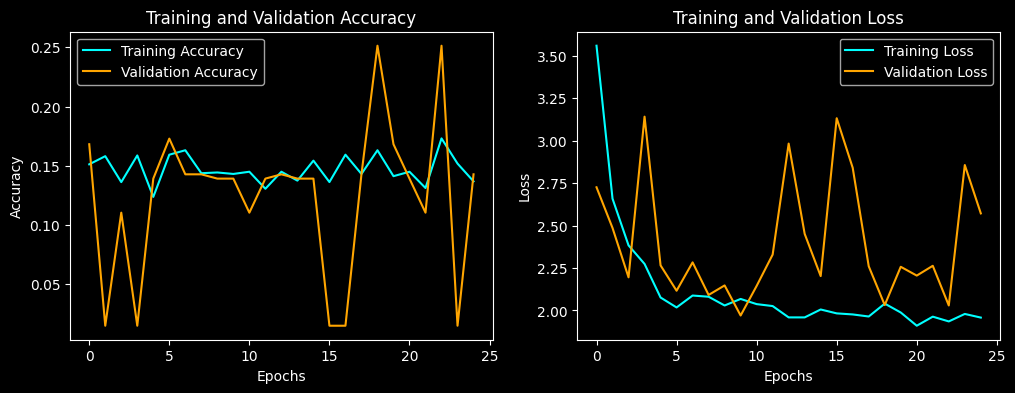

In [30]:
# Define class names (replace these with actual class names if available)
CLASS_NAMES = class_names# Ensure 'class_names' is defined in your code

# Function to plot accuracy and loss curves
def plot_training_curves(history):
    # Use a dark theme
    plt.style.use('dark_background')
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='cyan')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='cyan')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to plot curves
plot_training_curves(history)


In [31]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize lists for true labels and predictions
Y_true = []
Y_pred_classes = []

# Loop through validation data to get true labels and predictions
for X_batch, Y_batch in valid_data:
    # True labels
    Y_true.extend(Y_batch)
    # Predictions
    Y_pred = efficentNet.predict(X_batch)
    Y_pred_classes.extend(np.argmax(Y_pred, axis=1))  # Convert probabilities to class indices

# Convert lists to NumPy arrays
Y_true = np.array(Y_true)
Y_pred_classes = np.array(Y_pred_classes)


# Define class labels (ensure they match your training labels)
class_labels = class_names  # Replace CLASS_NAMES with your actual class names

# Generate and print the classification report
report = classification_report(Y_true, Y_pred_classes, target_names=class_labels)
print("Classification Report:\n", report)


# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Calculate normalized confusion matrix
conf_matrix_normalized = confusion_matrix(Y_true, Y_pred_classes, normalize='true')

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


KeyboardInterrupt: 